In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
%matplotlib notebook

In [2]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")
df_train['time_entry'] = pd.to_timedelta(df_train['time_entry'])
df_train['time_exit'] = pd.to_timedelta(df_train['time_exit'])
df_test['time_entry'] = pd.to_timedelta(df_test['time_entry'])
df_test['time_exit'] = pd.to_timedelta(df_test['time_exit'])
df_train['duration'] = df_train['time_exit'] - df_train['time_entry']
df_train['duration'] = df_train['duration'].dt.total_seconds()
df_test['duration'] = df_test['time_exit'] - df_test['time_entry']
df_test['duration'] = df_test['duration'].dt.total_seconds()

In [20]:
df_train['distance'] = df_train.apply(lambda row: (math.sqrt( ((row['x_entry'] - row['x_exit'])**2)+
                                                             ((row['y_entry']- row['y_exit'])**2) )), axis=1)

In [3]:
print(df_train.shape[0], df_train.hash.nunique(), df_test.shape[0], df_test.hash.nunique())

814262 134063 202937 33515


In [3]:
print(df_test[df_test['x_exit'].isnull()].time_entry.describe(), 
      df_test[df_test['x_exit'].isnull()].time_exit.describe())

count                     33515
mean     0 days 15:18:19.123317
std      0 days 00:19:59.072300
min             0 days 11:42:37
25%             0 days 15:04:34
50%             0 days 15:16:18
75%             0 days 15:33:00
max             0 days 16:00:00
Name: time_entry, dtype: object count                     33515
mean     0 days 15:25:12.903088
std      0 days 00:16:56.988681
min             0 days 15:00:00
25%             0 days 15:10:30
50%             0 days 15:22:55
75%             0 days 15:38:50
max             0 days 16:00:00
Name: time_exit, dtype: object


In [4]:
df = df_train.groupby('hash')
df_list = list(df)
df_2 = df_test.groupby('hash')
df_2_list = list(df_2)

In [5]:
tt = df_train[(df_train['x_exit'] >= 3750901.5068) & (df_train['x_exit'] <= 3770901.5068) & 
              (df_train['y_exit'] >= -19268905.6133) & (df_train['y_exit'] <= -19208905.6133)]
tt2 = df_test[(df_test['x_exit'] >= 3750901.5068) & (df_test['x_exit'] <= 3770901.5068) & 
              (df_test['y_exit'] >= -19268905.6133) & (df_test['y_exit'] <= -19208905.6133)]

In [6]:
def plot_trajectory(df_sample):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
#     for index, row in df_sample.iterrows():
#         arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
#                   label ='Trajectory', color = 'b')
    entries = plt.scatter(df_sample.x_entry,df_sample.y_entry, label='Entry point', color = 'b')
    exits = plt.scatter(df_sample.x_exit,df_sample.y_exit, label='Exit point', color = 'r')
    plt.legend(handles=[city, entries, exits])
    plt.grid(True)
    plt.show()

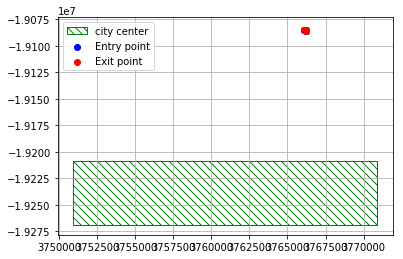

In [7]:
plot_trajectory(df_2_list[50][1])

In [8]:
for index, people in enumerate(df_2_list):
    if people[1].shape[0] <=2:
        print(index, ":",people[1].shape[0])

17 : 2
65 : 2
79 : 2
86 : 2
99 : 2
117 : 2
123 : 1
149 : 2
159 : 2
234 : 2
239 : 2
273 : 2
318 : 2
327 : 1
335 : 2
376 : 2
390 : 1
404 : 2
411 : 2
419 : 1
436 : 1
442 : 1
445 : 2
449 : 2
467 : 2
477 : 1
499 : 2
508 : 2
523 : 1
526 : 2
536 : 2
537 : 2
570 : 2
592 : 2
593 : 2
605 : 2
616 : 2
621 : 2
636 : 2
639 : 2
660 : 2
663 : 2
665 : 1
693 : 2
699 : 1
742 : 2
746 : 2
762 : 2
784 : 2
854 : 2
860 : 1
868 : 2
872 : 2
877 : 2
909 : 2
913 : 2
914 : 2
928 : 2
979 : 1
980 : 2
1032 : 2
1045 : 1
1046 : 2
1054 : 2
1071 : 2
1107 : 1
1124 : 2
1131 : 2
1183 : 2
1198 : 2
1263 : 1
1270 : 2
1277 : 2
1278 : 1
1293 : 2
1330 : 2
1346 : 2
1352 : 2
1353 : 2
1442 : 2
1456 : 2
1513 : 2
1515 : 2
1529 : 2
1534 : 2
1543 : 2
1584 : 1
1589 : 2
1592 : 2
1606 : 2
1622 : 2
1650 : 2
1661 : 2
1676 : 2
1680 : 1
1683 : 1
1684 : 2
1691 : 2
1723 : 2
1724 : 2
1752 : 2
1755 : 2
1769 : 2
1780 : 2
1864 : 2
1868 : 1
1916 : 2
1929 : 2
2008 : 2
2052 : 2
2061 : 1
2149 : 2
2162 : 2
2177 : 2
2200 : 2
2214 : 2
2216 : 2
2303 : 2
240

22723 : 2
22738 : 2
22740 : 2
22773 : 1
22838 : 1
22839 : 2
22845 : 2
22859 : 2
22861 : 2
22938 : 1
23003 : 2
23010 : 1
23027 : 2
23030 : 2
23051 : 2
23055 : 2
23065 : 2
23075 : 1
23088 : 1
23100 : 2
23101 : 2
23121 : 2
23138 : 2
23156 : 2
23184 : 2
23236 : 1
23275 : 2
23305 : 2
23323 : 2
23331 : 2
23356 : 2
23389 : 2
23409 : 2
23420 : 1
23422 : 2
23441 : 1
23448 : 2
23543 : 2
23548 : 2
23549 : 1
23552 : 2
23566 : 2
23578 : 2
23614 : 2
23670 : 1
23689 : 2
23701 : 2
23716 : 2
23737 : 2
23771 : 2
23816 : 2
23822 : 1
23861 : 2
23890 : 2
23892 : 2
23893 : 2
23906 : 2
23908 : 2
23913 : 2
23942 : 2
24007 : 2
24031 : 1
24068 : 1
24076 : 2
24087 : 2
24123 : 2
24136 : 2
24142 : 2
24147 : 1
24169 : 2
24184 : 1
24211 : 2
24220 : 2
24257 : 2
24259 : 2
24273 : 2
24282 : 2
24288 : 1
24291 : 1
24293 : 2
24306 : 2
24342 : 2
24361 : 2
24404 : 2
24413 : 2
24449 : 1
24477 : 2
24489 : 1
24532 : 2
24535 : 2
24537 : 2
24540 : 2
24549 : 2
24575 : 2
24581 : 2
24596 : 2
24599 : 2
24601 : 2
24658 : 1
24669 : 2


In [9]:
df_2_list[33332][1]

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,duration
201823,201823,fe852253ee80e3f10baf930e74461472_5,traj_fe852253ee80e3f10baf930e74461472_5_0,14:56:02,15:09:00,NaN,NaN,NaN,3.771895e+06,-1.933505e+07,NaN,NaN,778.0


In [24]:
df_train.duration.describe()

count    814262.000000
mean        347.010594
std         623.143284
min           0.000000
25%           0.000000
50%           0.000000
75%         480.000000
max       24577.000000
Name: duration, dtype: float64

In [32]:
df_train[(df_train['duration'] == 0.0) & (df_train['x_entry'] == df_train['x_exit']) &
         (df_train['y_entry'] == df_train['y_exit'])].shape[0]

432985

In [35]:
df_train[(df_train['duration'] == 0.0) & ((df_train['x_entry'] != df_train['x_exit']) |
         (df_train['y_entry'] != df_train['y_exit']))]

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,duration,distance
8651,8651,02b13a4497b8c1ae9e2dfe6ffe22e564_31,traj_02b13a4497b8c1ae9e2dfe6ffe22e564_31_2,10:13:35,10:13:35,NaN,NaN,NaN,3.776593e+06,-1.916947e+07,3.776584e+06,-1.916929e+07,0.0,180.517210
19997,19997,064adf11a010dcc0734ac3dcee20a9d6_1,traj_064adf11a010dcc0734ac3dcee20a9d6_1_8,12:22:03,12:22:03,NaN,NaN,NaN,3.767824e+06,-1.920685e+07,3.767829e+06,-1.920675e+07,0.0,102.108170
25837,25837,081a398f286d9c7eb0097c4ddd41d553_29,traj_081a398f286d9c7eb0097c4ddd41d553_29_23,11:04:03,11:04:03,NaN,NaN,NaN,3.771995e+06,-1.931883e+07,3.772002e+06,-1.931890e+07,0.0,69.528648
28420,28420,08d3c5af1a15e914a1cad358b7a58902_15,traj_08d3c5af1a15e914a1cad358b7a58902_15_5,10:45:09,10:45:09,NaN,NaN,NaN,3.746278e+06,-1.935705e+07,3.746254e+06,-1.935686e+07,0.0,187.260729
41841,41841,0d04a5d9f33926823c9760066730cbe9_31,traj_0d04a5d9f33926823c9760066730cbe9_31_3,14:44:33,14:44:33,NaN,NaN,NaN,3.752328e+06,-1.928389e+07,3.752315e+06,-1.928408e+07,0.0,195.479221
45363,45363,0e14beedbad7338c8ca6d95315f6b60e_31,traj_0e14beedbad7338c8ca6d95315f6b60e_31_5,11:09:32,11:09:32,NaN,NaN,NaN,3.757857e+06,-1.926401e+07,3.757845e+06,-1.926387e+07,0.0,149.085116
63060,63060,13a5a774d487f2084925dfbf06b2a38a_19,traj_13a5a774d487f2084925dfbf06b2a38a_19_31,15:11:12,15:11:12,NaN,NaN,NaN,3.757773e+06,-1.926994e+07,3.757772e+06,-1.926998e+07,0.0,34.358487
66425,66425,14b833d80fe855e946a3ccd93550ac66_15,traj_14b833d80fe855e946a3ccd93550ac66_15_1,13:46:05,13:46:05,NaN,NaN,NaN,3.742884e+06,-1.931958e+07,3.742874e+06,-1.931991e+07,0.0,323.165955
76327,76327,17c116305445e7d8bc6f5c54028c99e1_9,traj_17c116305445e7d8bc6f5c54028c99e1_9_8,10:00:18,10:00:18,NaN,NaN,NaN,3.744661e+06,-1.928762e+07,3.744675e+06,-1.928740e+07,0.0,218.565523
79287,79287,18ad12e346b46ce452f8bbe2860e1680_31,traj_18ad12e346b46ce452f8bbe2860e1680_31_1,01:21:19,01:21:19,NaN,NaN,NaN,3.749178e+06,-1.922135e+07,3.749179e+06,-1.922141e+07,0.0,56.812789


In [162]:
df_test[(df_test['duration'] == 0.0) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].shape[0]

16841

In [40]:
df_train['velocity'] = df_train.apply(lambda row: (row['distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)

In [84]:
df_train[(df_train['velocity'] != 0.0) & (df_train['velocity'] < 500)].velocity.describe()

count    377930.000000
mean         38.950397
std          57.742434
min           0.001118
25%           3.147787
50%          16.283459
75%          50.864415
max         499.764922
Name: velocity, dtype: float64

In [73]:
df_train[(df_train['velocity'] != 0.0)].velocity.describe()

count    380152.000000
mean         51.483492
std         440.278649
min           0.001118
25%           3.187148
50%          16.565050
75%          51.840017
max       78910.312250
Name: velocity, dtype: float64

In [66]:
df_train = df_train.drop(df_train.index[643223])

In [85]:
380152.000000 - 377930.000000

2222.0

In [118]:
df_test[(df_test['duration'] > 0) & (df_test['duration'] < 5000) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].duration.describe()

count    16624.000000
mean       814.762452
std        723.626257
min          1.000000
25%        312.000000
50%        593.000000
75%       1101.000000
max       4951.000000
Name: duration, dtype: float64

<IPython.core.display.Javascript object>


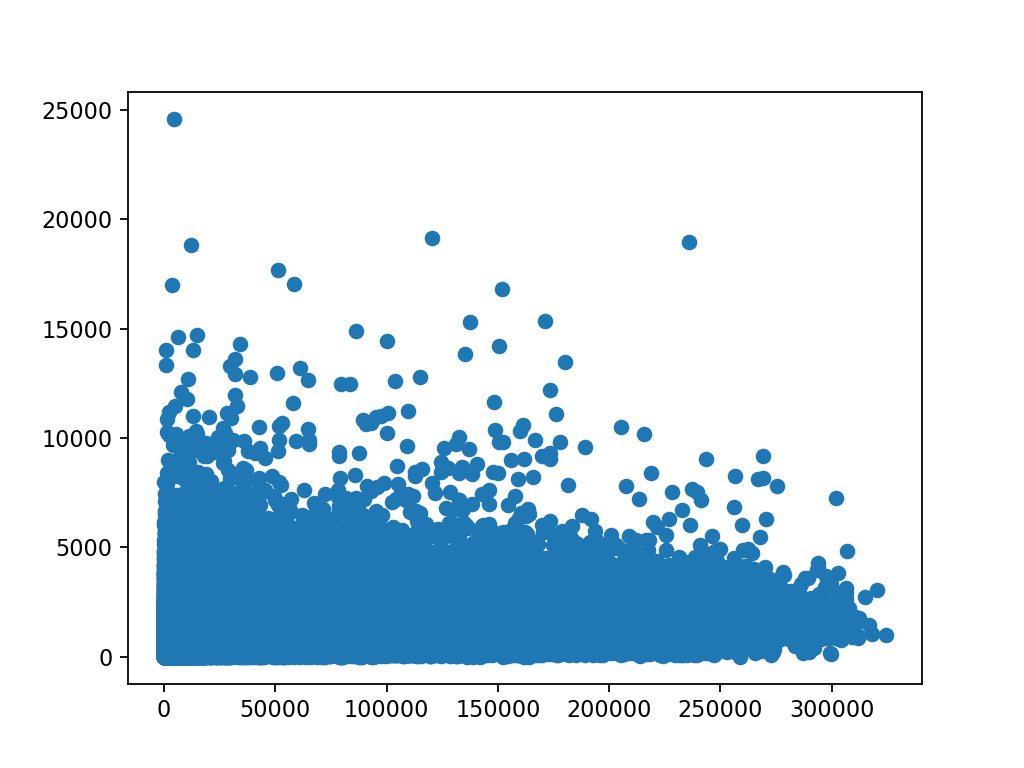

In [124]:
plt.scatter(df_train[df_train['velocity'] != 0.0].distance, df_train[df_train['velocity'] != 0.0].duration)

In [185]:
df_test['label']= -1

In [186]:
df_test['label'] = df_test.apply(lambda row: 1 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                      (row['x_entry'] >= 3750901.5068) & (row['x_entry'] <= 3770901.5068) & 
                                      (row['y_entry'] >= -19268905.6133) & (row['y_entry'] <= -19208905.6133)) 
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1))
                                 else row['label'], axis=1)

In [189]:
df_test[df_test.x_exit.isnull()]['label'].value_counts()

0    28654
1     4861
Name: label, dtype: int64

In [188]:
df_test['label'] = df_test['label'].replace(-1,0)

In [190]:
df_test[df_test.x_exit.isnull()][['trajectory_id', 'label']].to_csv('output.csv', index=False)

In [182]:
21535 + 11980

33515